In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import re
%matplotlib inline
sns.set()

from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Data Cleaning

In [69]:
crime1 = pd.read_csv("./input/crime1.csv")
crime2 = pd.read_csv("./input/crime2.csv")

In [70]:
'''
    OFFENSE_CATEGORY_ID : 14가지 범주 예측을 위해, one-hot-encoding
'''
df = pd.concat([crime1,crime2],axis=0,ignore_index=True)

In [75]:
df.head()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC
0,2016376978,2016376978521300,5213,0,weapon-unlawful-discharge-of,all-other-crimes,6/15/2016 11:31:00 PM,NaN,6/15/2016 11:31:00 PM,NaN,3193983.0,1707251.0,-104.809881,39.773188,5,521,montbello,1,0
1,20186000994,20186000994239900,2399,0,theft-other,larceny,10/11/2017 12:30:00 PM,10/11/2017 4:55:00 PM,1/29/2018 5:53:00 PM,NaN,3201943.0,1711852.0,-104.781434,39.785649,5,522,gateway-green-valley-ranch,1,0
2,20166003953,20166003953230500,2305,0,theft-items-from-vehicle,theft-from-motor-vehicle,3/4/2016 8:00:00 PM,4/25/2016 8:00:00 AM,4/26/2016 9:02:00 PM,2932 S JOSEPHINE ST,3152762.0,1667011.0,-104.957381,39.663490,3,314,wellshire,1,0
3,201872333,201872333239900,2399,0,theft-other,larceny,1/30/2018 7:20:00 PM,NaN,1/30/2018 10:29:00 PM,705 S COLORADO BLVD,3157162.0,1681320.0,-104.941440,39.702698,3,312,belcaro,1,0
4,2017411405,2017411405230300,2303,0,theft-shoplift,larceny,6/22/2017 8:53:00 PM,NaN,6/23/2017 4:09:00 PM,2810 E 1ST AVE,3153211.0,1686545.0,-104.955370,39.717107,3,311,cherry-creek,1,0


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526101 entries, 0 to 526100
Data columns (total 19 columns):
INCIDENT_ID               526101 non-null int64
OFFENSE_ID                526101 non-null int64
OFFENSE_CODE              526101 non-null int64
OFFENSE_CODE_EXTENSION    526101 non-null int64
OFFENSE_TYPE_ID           526101 non-null object
OFFENSE_CATEGORY_ID       526101 non-null object
FIRST_OCCURRENCE_DATE     526101 non-null object
LAST_OCCURRENCE_DATE      166714 non-null object
REPORTED_DATE             526101 non-null object
INCIDENT_ADDRESS          474738 non-null object
GEO_X                     521725 non-null float64
GEO_Y                     521725 non-null float64
GEO_LON                   521725 non-null float64
GEO_LAT                   521725 non-null float64
DISTRICT_ID               526101 non-null int64
PRECINCT_ID               526101 non-null int64
NEIGHBORHOOD_ID           526101 non-null object
IS_CRIME                  526101 non-null int64
IS_TRAFFIC

In [5]:
df.FIRST_OCCURRENCE_DATE = pd.to_datetime(df.FIRST_OCCURRENCE_DATE)
'''
    월별,일별,시간별 분석을 위해 만듬.
'''
# df["DAY"] = df.FIRST_OCCURRENCE_DATE.dt.day
# df["DAY_OF_WEEK"] = df.FIRST_OCCURRENCE_DATE.dt.dayofweek
# df["MONTH"] = df.FIRST_OCCURRENCE_DATE.dt.month
df["YEAR"] = df.FIRST_OCCURRENCE_DATE.dt.year
df["HOUR"] = df.FIRST_OCCURRENCE_DATE.dt.hour
#사건 발생 날짜로 인덱스 변환
df.index = pd.DatetimeIndex(df["FIRST_OCCURRENCE_DATE"])

In [6]:
df.head()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,...,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC,YEAR,HOUR
FIRST_OCCURRENCE_DATE,,,,,,,,,,,,,,,,,,,,,
2016-06-15 23:31:00,2016376978,2016376978521300,5213,0,weapon-unlawful-discharge-of,all-other-crimes,2016-06-15 23:31:00,NaN,6/15/2016 11:31:00 PM,NaN,...,1707251.0,-104.809881,39.773188,5,521,montbello,1,0,2016,23
2017-10-11 12:30:00,20186000994,20186000994239900,2399,0,theft-other,larceny,2017-10-11 12:30:00,10/11/2017 4:55:00 PM,1/29/2018 5:53:00 PM,NaN,...,1711852.0,-104.781434,39.785649,5,522,gateway-green-valley-ranch,1,0,2017,12
2016-03-04 20:00:00,20166003953,20166003953230500,2305,0,theft-items-from-vehicle,theft-from-motor-vehicle,2016-03-04 20:00:00,4/25/2016 8:00:00 AM,4/26/2016 9:02:00 PM,2932 S JOSEPHINE ST,...,1667011.0,-104.957381,39.663490,3,314,wellshire,1,0,2016,20
2018-01-30 19:20:00,201872333,201872333239900,2399,0,theft-other,larceny,2018-01-30 19:20:00,NaN,1/30/2018 10:29:00 PM,705 S COLORADO BLVD,...,1681320.0,-104.941440,39.702698,3,312,belcaro,1,0,2018,19
2017-06-22 20:53:00,2017411405,2017411405230300,2303,0,theft-shoplift,larceny,2017-06-22 20:53:00,NaN,6/23/2017 4:09:00 PM,2810 E 1ST AVE,...,1686545.0,-104.955370,39.717107,3,311,cherry-creek,1,0,2017,20


## 시간대 별 사건 발생

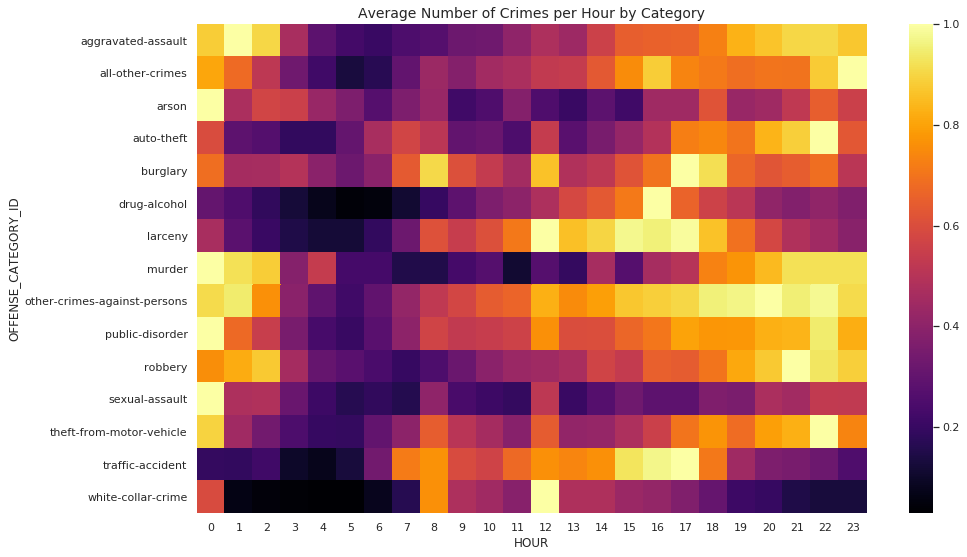

In [7]:
'''
    범죄가 시간적 특징을 어느정도 가지는 것으로 보인다
'''
crimes_hour_pt = df.pivot_table(index='OFFENSE_CATEGORY_ID', columns='HOUR', aggfunc='size')
crimes_hour_pt = crimes_hour_pt.apply(lambda x: x / crimes_hour_pt.max(axis=1))
plt.figure(figsize=(15,9))
plt.title('Average Number of Crimes per Hour by Category', fontsize=14)
sns.heatmap(crimes_hour_pt, cmap='inferno', cbar=True, annot=False, fmt=".0f");

## 범죄 구역

In [8]:
crimes_df = df[df.IS_CRIME==1]
crimes_df = crimes_df.dropna(subset=['GEO_LAT', 'GEO_LON'])
robbery_dfs =[crimes_df[(crimes_df.OFFENSE_CATEGORY_ID=='white-collar-crime') & (crimes_df.YEAR==2018)]]
for i,CATEGORY_ID in enumerate(crimes_df.OFFENSE_CATEGORY_ID.unique()[10:]):
    robbery_dfs.append(crimes_df[(crimes_df.OFFENSE_CATEGORY_ID==CATEGORY_ID) & (crimes_df.YEAR==2018)])


In [9]:
denver_maps=[]
for i,robbery_df in enumerate(robbery_dfs):
    denver_map = folium.Map(location=[39.72378, -104.899157],
                           zoom_start=12,
                           tiles="CartoDB dark_matter")
    for i in range(len(robbery_df)):
        lat = robbery_df.iloc[i]['GEO_LAT']
        long = robbery_df.iloc[i]['GEO_LON']
        popup_text = """Neighborhood: {}<br>
                        Date Occurred: {}<br>""".format(crimes_df.iloc[i]['NEIGHBORHOOD_ID'],
                                                   crimes_df.iloc[i]['FIRST_OCCURRENCE_DATE'])
        folium.CircleMarker(location=[lat, long], popup=popup_text, radius=8, color='#800080', fill=True).add_to(denver_map)
    denver_maps.append(denver_map)

In [10]:
'''
    지역별 뚜렷한 특징은 보이지 않으나, 전반적인 특징은 있을것으로 예상. base line 특징으로 잡음.
'''
print('white-collar-crime')
denver_maps[0]

white-collar-crime


In [11]:
print(crimes_df.OFFENSE_CATEGORY_ID.unique()[10])
denver_maps[1]

robbery


In [12]:
print(crimes_df.OFFENSE_CATEGORY_ID.unique()[11])
denver_maps[2]

murder


In [13]:
print(crimes_df.OFFENSE_CATEGORY_ID.unique()[12])
denver_maps[3]

arson


In [14]:
df.head()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,...,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC,YEAR,HOUR
FIRST_OCCURRENCE_DATE,,,,,,,,,,,,,,,,,,,,,
2016-06-15 23:31:00,2016376978,2016376978521300,5213,0,weapon-unlawful-discharge-of,all-other-crimes,2016-06-15 23:31:00,NaN,6/15/2016 11:31:00 PM,NaN,...,1707251.0,-104.809881,39.773188,5,521,montbello,1,0,2016,23
2017-10-11 12:30:00,20186000994,20186000994239900,2399,0,theft-other,larceny,2017-10-11 12:30:00,10/11/2017 4:55:00 PM,1/29/2018 5:53:00 PM,NaN,...,1711852.0,-104.781434,39.785649,5,522,gateway-green-valley-ranch,1,0,2017,12
2016-03-04 20:00:00,20166003953,20166003953230500,2305,0,theft-items-from-vehicle,theft-from-motor-vehicle,2016-03-04 20:00:00,4/25/2016 8:00:00 AM,4/26/2016 9:02:00 PM,2932 S JOSEPHINE ST,...,1667011.0,-104.957381,39.663490,3,314,wellshire,1,0,2016,20
2018-01-30 19:20:00,201872333,201872333239900,2399,0,theft-other,larceny,2018-01-30 19:20:00,NaN,1/30/2018 10:29:00 PM,705 S COLORADO BLVD,...,1681320.0,-104.941440,39.702698,3,312,belcaro,1,0,2018,19
2017-06-22 20:53:00,2017411405,2017411405230300,2303,0,theft-shoplift,larceny,2017-06-22 20:53:00,NaN,6/23/2017 4:09:00 PM,2810 E 1ST AVE,...,1686545.0,-104.955370,39.717107,3,311,cherry-creek,1,0,2017,20


### 전처리

In [15]:
'''
    -총 데이터 60만개.
    -날짜 데이터 삭제.
    -13 class 남음
'''
df = df.drop(["INCIDENT_ID","OFFENSE_ID","FIRST_OCCURRENCE_DATE","LAST_OCCURRENCE_DATE","REPORTED_DATE","INCIDENT_ADDRESS","YEAR"],axis=1)
df.head()

'''
    NAN 제거 , 4000여개
'''
df.isnull().sum()
df = df.dropna(axis=0)
df = df.reset_index(drop=True)
df.shape
df.isnull().sum()

OFFENSE_CODE              0
OFFENSE_CODE_EXTENSION    0
OFFENSE_TYPE_ID           0
OFFENSE_CATEGORY_ID       0
GEO_X                     0
GEO_Y                     0
GEO_LON                   0
GEO_LAT                   0
DISTRICT_ID               0
PRECINCT_ID               0
NEIGHBORHOOD_ID           0
IS_CRIME                  0
IS_TRAFFIC                0
HOUR                      0
dtype: int64

In [16]:
numeric_columns_name = df.columns[4:8]
category_columns_name = df.columns[:4].append(df.columns[8:])

In [17]:
category_columns_name

Index(['OFFENSE_CODE', 'OFFENSE_CODE_EXTENSION', 'OFFENSE_TYPE_ID',
       'OFFENSE_CATEGORY_ID', 'DISTRICT_ID', 'PRECINCT_ID', 'NEIGHBORHOOD_ID',
       'IS_CRIME', 'IS_TRAFFIC', 'HOUR'],
      dtype='object')

In [18]:
'''
    numeric / category 분리
'''
df_numeric = df.drop(["OFFENSE_CATEGORY_ID","HOUR","OFFENSE_CODE","OFFENSE_CODE_EXTENSION",
                      "OFFENSE_TYPE_ID","DISTRICT_ID","PRECINCT_ID","NEIGHBORHOOD_ID","IS_CRIME","IS_TRAFFIC"],axis=1)
df_category = df.drop(["OFFENSE_CATEGORY_ID","GEO_X","GEO_Y","GEO_LON","GEO_LAT"],axis=1)

In [19]:
df_category.head()

,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC,HOUR
0,5213,0,weapon-unlawful-discharge-of,5,521,montbello,1,0,23
1,2399,0,theft-other,5,522,gateway-green-valley-ranch,1,0,12
2,2305,0,theft-items-from-vehicle,3,314,wellshire,1,0,20
3,2399,0,theft-other,3,312,belcaro,1,0,19
4,2303,0,theft-shoplift,3,311,cherry-creek,1,0,20


In [20]:
category_columns_name

Index(['OFFENSE_CODE', 'OFFENSE_CODE_EXTENSION', 'OFFENSE_TYPE_ID',
       'OFFENSE_CATEGORY_ID', 'DISTRICT_ID', 'PRECINCT_ID', 'NEIGHBORHOOD_ID',
       'IS_CRIME', 'IS_TRAFFIC', 'HOUR'],
      dtype='object')

In [21]:
for name in df_category.columns:
    print('{} : {} '.format(name,len(df[name].value_counts())))

OFFENSE_CODE : 151 
OFFENSE_CODE_EXTENSION : 6 
OFFENSE_TYPE_ID : 193 
DISTRICT_ID : 7 
PRECINCT_ID : 36 
NEIGHBORHOOD_ID : 78 
IS_CRIME : 2 
IS_TRAFFIC : 2 
HOUR : 24 


### numeric 정규화

In [22]:
'''
    1. MinMaxScaler() 적용을 위해 matrix 변환
    2. fit()
    3. transform : 0~1 사이 값으로 변환
    4. pandas 재구성
'''
#df_columns name 저장
df_numeric_col = list(df_numeric.columns)

mat_df_numeric = np.matrix(df_numeric)
prepro = MinMaxScaler()
prepro.fit(mat_df_numeric)
df_numeric = pd.DataFrame(prepro.transform(mat_df_numeric),columns = df_numeric_col)
df_numeric.head()

,GEO_X,GEO_Y,GEO_LON,GEO_LAT
0,0.078525,0.149518,0.092273,0.996714
1,0.078721,0.149921,0.092519,0.997026
2,0.077511,0.145994,0.090995,0.993965
3,0.077620,0.147247,0.091133,0.994948
4,0.077523,0.147705,0.091013,0.995309


In [23]:
df_category.columns

Index(['OFFENSE_CODE', 'OFFENSE_CODE_EXTENSION', 'OFFENSE_TYPE_ID',
       'DISTRICT_ID', 'PRECINCT_ID', 'NEIGHBORHOOD_ID', 'IS_CRIME',
       'IS_TRAFFIC', 'HOUR'],
      dtype='object')

In [24]:
concat_temp = df_category.drop(['OFFENSE_CODE', 'OFFENSE_CODE_EXTENSION', 'OFFENSE_TYPE_ID',
       'DISTRICT_ID', 'PRECINCT_ID', 'NEIGHBORHOOD_ID', 'IS_CRIME',
       'IS_TRAFFIC', 'HOUR'],axis=1)

In [25]:
Several_category=[df_numeric]
#concat_temp=df_numeric
for i in range(len(df_category.columns)):
    # column plus
    concat_temp= pd.concat([concat_temp,df_category[df_category.columns[-i-1]]],axis=1)
    #one-hot
    df_category_one_hot = pd.get_dummies(concat_temp.astype(str))   
    Several_category.append(pd.concat([df_category_one_hot,df_numeric],axis=1))

## OFFENSE_CATEGORY_ID를 예측해보자. 

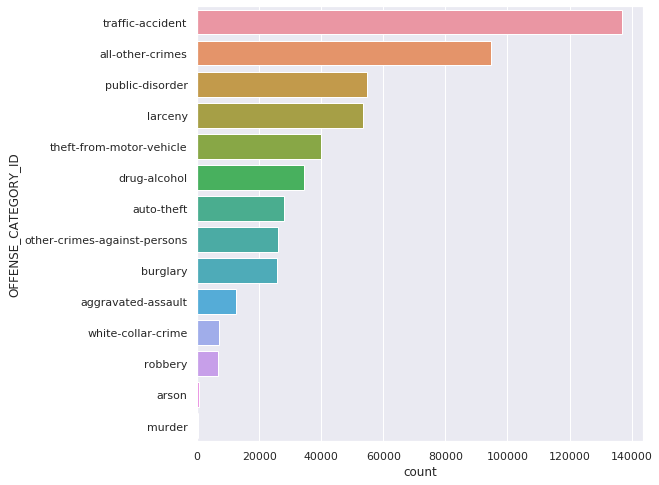

In [26]:
plt.figure(figsize=(8,8))
cat_freq = df.OFFENSE_CATEGORY_ID.value_counts()
'''
    y     : pandas column
    data  : 인수가 되는 dataframe
    order : 카테고리 level을 ploting하는 순서
'''
sns.countplot(y="OFFENSE_CATEGORY_ID", data=df, order=cat_freq.index)

In [27]:
'''
    pd.get_dummies :  One-hot 인코딩
    target : OFFENSE_CATEGORY_ID 정답 label
'''
def get_one_hot(df,column_name):
    df_one_hot_encoded = pd.get_dummies(df[column_name])
    target = np.array(df_one_hot_encoded)
    return target

one_hot_target = get_one_hot(df,"OFFENSE_CATEGORY_ID")
target = np.argmax(one_hot_target,axis=1)

### Classification - FC-layer (One-hot encoding, numeric)

In [28]:
class Model(nn.Module):
    def __init__(self,prepro_df):
        super(Model,self).__init__()

        self.linear1 = nn.Linear(prepro_df.shape[1],50) 
        self.linear2 = nn.Linear(50,100) 
        self.linear3 = nn.Linear(100,14)
        
    def forward(self, inputs):

        inputs = F.leaky_relu(self.linear1(inputs))
        inputs = F.leaky_relu(self.linear2(inputs))
        inputs = F.leaky_relu(self.linear3(inputs))
        return inputs

In [29]:
def loader(Several_category):
    train, test, train_target, test_target = train_test_split(Several_category,target,test_size=0.25,random_state=123)
    train = np.array(train)
    test = np.array(test)

    train = torch.from_numpy(train)
    train_target = torch.from_numpy(train_target)

    dataset= TensorDataset(train,train_target)
    dataloader = DataLoader(dataset, batch_size = 512, shuffle=True)

    test = torch.from_numpy(test)
    test_target = torch.from_numpy(test_target)

    test_dataset= TensorDataset(test,test_target)
    testloader = DataLoader(test_dataset, batch_size = 512, shuffle=True)
    return dataloader, testloader

In [30]:
epoch = 5
learning_rate = 1e-4

for j in range(len(Several_category)):
    correct = 0
    total = 0
    
    dataloader,testloader = loader(Several_category[j])
    
    model = Model(Several_category[j])
    model = nn.DataParallel(model).cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer= optim.Adam(model.parameters(),lr=learning_rate)

    for e in range(epoch):
        running_loss =0.0
        for i, data in enumerate(dataloader,0):
            inputs, labels = data
            inputs = inputs.float().cuda()
            labels = labels.long().cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss =criterion(outputs,labels)
            loss.backward()
            optimizer.step()

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data

            inputs = inputs.float().cuda()
            labels = labels.float().cuda()

            outputs = model(inputs)
            '''
                outputs.data : 각 노드들의 값
                torch.max(outputs.data , 1)
                0차원 :배치 단위
                1차원 : 각 노드들의 값
                predicted : max 값 배열[ , , , ]
                (predicted == labels) : true , false
                (predicted == labels).sum().item() : ture 합쳐서 개수
            '''
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    if j == 0:
        print("training attribute : ",list(df_numeric))
    else:
        print("training attribute : ",list(df_numeric),"+",list(df_category.columns[-j:]))
    print('test images Accuracy: %d %%' % (100 * correct / total))
    print()

training attribute :  ['GEO_X', 'GEO_Y', 'GEO_LON', 'GEO_LAT']
test images Accuracy: 26 %

training attribute :  ['GEO_X', 'GEO_Y', 'GEO_LON', 'GEO_LAT'] + ['HOUR']
test images Accuracy: 29 %

training attribute :  ['GEO_X', 'GEO_Y', 'GEO_LON', 'GEO_LAT'] + ['IS_TRAFFIC', 'HOUR']
test images Accuracy: 44 %

training attribute :  ['GEO_X', 'GEO_Y', 'GEO_LON', 'GEO_LAT'] + ['IS_CRIME', 'IS_TRAFFIC', 'HOUR']
test images Accuracy: 44 %

training attribute :  ['GEO_X', 'GEO_Y', 'GEO_LON', 'GEO_LAT'] + ['NEIGHBORHOOD_ID', 'IS_CRIME', 'IS_TRAFFIC', 'HOUR']
test images Accuracy: 47 %

training attribute :  ['GEO_X', 'GEO_Y', 'GEO_LON', 'GEO_LAT'] + ['PRECINCT_ID', 'NEIGHBORHOOD_ID', 'IS_CRIME', 'IS_TRAFFIC', 'HOUR']
test images Accuracy: 47 %

training attribute :  ['GEO_X', 'GEO_Y', 'GEO_LON', 'GEO_LAT'] + ['DISTRICT_ID', 'PRECINCT_ID', 'NEIGHBORHOOD_ID', 'IS_CRIME', 'IS_TRAFFIC', 'HOUR']
test images Accuracy: 47 %

training attribute :  ['GEO_X', 'GEO_Y', 'GEO_LON', 'GEO_LAT'] + ['OFFENSE_TY